In [1]:
import pandas as pd
from pathlib import Path

streams_features_file = r"/Users/James/Documents/Python/Machine Learning Projects/Spotify_Listening_Analysis/Spotify 2.0/preprocessing/pickles/my_features.pkl"
streams_features_raw = pd.read_pickle(streams_features_file)
streams_features = streams_features_raw.copy()


columns_to_drop = ["type", "id", "uri", "track_href", "analysis_url", "time_signature"]
streams_features.drop(columns_to_drop, inplace=True, axis=1)


def convert_duration(dataframe=streams_features):
    dataframe["duration"] = dataframe["duration_ms"].divide(60000)
    dataframe.drop("duration_ms", axis=1, inplace=True)
    return dataframe


def add_play_count(dataframe=streams_features):
    dataframe["playCount"] = dataframe["minutesTotal"] / dataframe["duration"]
    return dataframe


streams_features = convert_duration(streams_features)
streams_features = add_play_count(streams_features)

streams_features = streams_features[
    (streams_features["artistName"] != "John Mayer")
    & (streams_features["trackName"] != "On The Way Home")
]  # this one song has an incorrect duration and is returning a 30+ play count, definitely something not right


/Users/James/.pyenv/versions/3.8.5/envs/ml_env/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def plot_loss(model_history, exp = False):
    if exp:
        plt.plot(pd.DataFrame(np.exp(model_history.history["loss"])), label = "loss")
        plt.plot(pd.DataFrame(np.exp(model_history.history["val_loss"])), label = "val_loss")
    else:
        plt.plot(pd.DataFrame(model_history.history["loss"]), label = "loss")
        plt.plot(pd.DataFrame(model_history.history["val_loss"]), label = "val_loss")
    plt.grid(True)
    #plt.gca().set_ylim(0, 10)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [3]:
def plot_hist(model):
    fig, ax = plt.subplots(figsize=(7,5));
    ax = sns.histplot(data = model, x = "playCount", stat = "count", kde = True)
    return ax

In [4]:
streams_features[streams_features["playCount"]==0].count()

artistName          182
trackName           182
minutesTotal        182
trackId             182
danceability        182
energy              182
key                 182
loudness            182
mode                182
speechiness         182
acousticness        182
instrumentalness    182
liveness            182
valence             182
tempo               182
duration            182
playCount           182
dtype: int64

In [5]:
streams_features.count()

artistName          8443
trackName           8443
minutesTotal        8443
trackId             8443
danceability        8443
energy              8443
key                 8443
loudness            8443
mode                8443
speechiness         8443
acousticness        8443
instrumentalness    8443
liveness            8443
valence             8443
tempo               8443
duration            8443
playCount           8443
dtype: int64

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='playCount', ylabel='Count'>

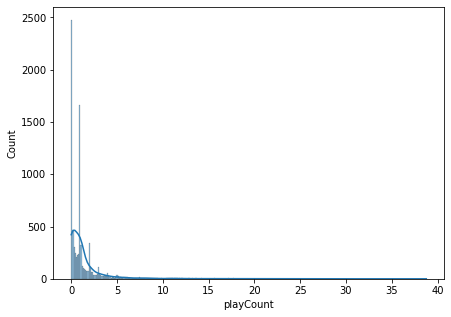

In [7]:
plot_hist(streams_features)

In [8]:
streams_features["playCount"].skew() #Prior to transformation

5.095245716380945

In [310]:
#Trying Boxcox transformation
# from scipy import stats
# streams_features = streams_features[streams_features["playCount"]>0]
# plays = streams_features["playCount"].to_numpy()
# plays,_ = stats.boxcox(plays)
# streams_features["playCount"] = plays
# streams_features["playCount"].skew()

Trying to normalize the data through log transformation

In [311]:
#Removing outliers 
# streams_features = streams_features[streams_features["playCount"]<5]
# streams_features = streams_features[streams_features["playCount"]>=0.5]
# streams_features.count()
# sns.histplot(data = streams_features, x = "playCount", stat = "count", kde = True)

In [9]:
#Cap most played songs at 10
streams_features["playCount"].where(streams_features["playCount"] <= 10, 10, inplace=True)

/Users/James/.pyenv/versions/3.8.5/envs/ml_env/lib/python3.8/site-packages/pandas/core/generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(


<AxesSubplot:xlabel='playCount', ylabel='Count'>

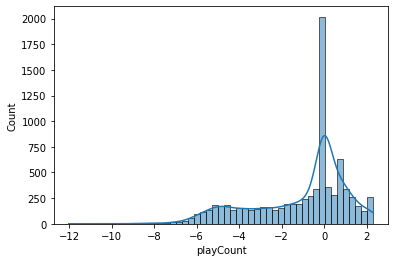

In [11]:
import numpy as np
no_zeroes = streams_features[streams_features["playCount"]>0]
log_dist = np.log(no_zeroes["playCount"])
sns.histplot(data = log_dist, stat = "count", kde = True)

In [12]:
# fig, axs = plt.subplots(1,3,figsize=(12,5))
# sns.histplot(data = no_zeroes["playCount"], stat = "count", kde = True, ax = axs[0])
# sns.histplot(data = log_dist2, stat = "count", kde = True, ax = axs[1])
# sns.histplot(data = sqrt_dist, stat = "count", kde = True, ax = axs[2])

In [13]:
streams_features = streams_features[streams_features["playCount"]>0]
streams_features["playCount"] = np.log(no_zeroes["playCount"])

In [14]:
streams_features["playCount"].skew() #After  transformation

-0.9086037543394033

In [15]:
streams_features["playCount"].count()

8261

In [16]:
corr_matrix = streams_features.corr()
corr_matrix["playCount"].sort_values(ascending=False)

playCount           1.000000
minutesTotal        0.507955
acousticness        0.097303
instrumentalness    0.091186
mode                0.027466
key                 0.004854
liveness           -0.032592
duration           -0.034313
tempo              -0.037245
speechiness        -0.052461
valence            -0.053775
danceability       -0.078444
loudness           -0.104600
energy             -0.107586
Name: playCount, dtype: float64

<AxesSubplot:>

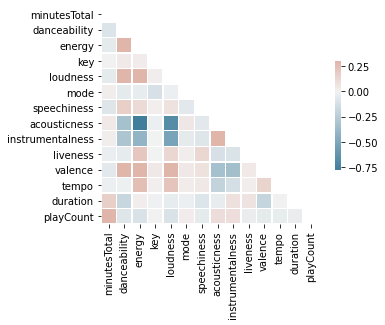

In [17]:
import numpy as np
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
X = streams_features.drop(["artistName", "trackName", "minutesTotal", "trackId", "playCount"], axis = 1)
y = streams_features["playCount"]

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
standard_scalar  = StandardScaler()
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)
#X = pt.fit_transform(X)

In [21]:
# pt = PowerTransformer(method='yeo-johnson')
# data = pt.fit_transform(X)
# # convert the array back to a dataframe
# dataset = pd.DataFrame(data)
# # histograms of the variables
# dataset.hist()
# plt.show()

In [22]:
len(X)

8261

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [26]:
X_lengths = {"X_train" : len(X_train), "X_test" : len(X_test), "X_valid" : len(X_valid)}
y_lengths = {"y_train" : len(y_train), "y_test" : len(y_test), "y_valid" : len(y_valid)}

In [27]:
X_lengths, y_lengths

({'X_train': 5947, 'X_test': 1653, 'X_valid': 661},
 {'y_train': 5947, 'y_test': 1653, 'y_valid': 661})

In [28]:
import tensorflow as tf
from tensorflow import keras

In [29]:
model_params = {
    "optimizer":keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), 
    "loss": tf.keras.losses.MeanAbsoluteError(),
    "hidden_activation":"relu",
    "output_activation":"relu",  
    #"loss":keras.losses.Huber(), 
    "initializer" : tf.keras.initializers.HeNormal()
}

In [30]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75,
                              patience=2, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,min_delta = 0.0001)

In [31]:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation=model_params["hidden_activation"], input_shape=X_train.shape[1:], 
                       kernel_initializer=model_params["initializer"]),
    #keras.layers.Dense(50, activation=model_params["hidden_activation"]),
    #keras.layers.Dense(30, activation=model_params["hidden_activation"]),
    #keras.layers.Dense(25, activation=model_params["hidden_activation"],kernel_initializer=model_params["initializer"]),
    keras.layers.Dense(20, activation=model_params["hidden_activation"],kernel_initializer=model_params["initializer"]),
    keras.layers.Dense(1, activation=model_params["output_activation"]),
])

model.compile(loss=model_params["loss"], 
              optimizer=model_params["optimizer"])

In [32]:
loss_min = {}
val_loss_min = {}
for i in [250]:
    history = model.fit(X_train, 
                    y_train, 
                    epochs=i, 
                    verbose = 1, 
                    validation_data=(X_valid, y_valid),
                    callbacks = [early_stopping, reduce_lr],
                    batch_size = 32)
    loss_min[i] = min(history.history["loss"])
    val_loss_min[i] = min(history.history["val_loss"])

Epoch 1/250
186/186 [==============================] - 0s 2ms/step - loss: 1.8752 - val_loss: 1.8327
Epoch 2/250
186/186 [==============================] - 0s 1ms/step - loss: 1.8438 - val_loss: 1.8019
Epoch 3/250
186/186 [==============================] - 0s 2ms/step - loss: 1.8158 - val_loss: 1.7750
Epoch 4/250
186/186 [==============================] - 0s 2ms/step - loss: 1.7907 - val_loss: 1.7512
Epoch 5/250
186/186 [==============================] - 0s 2ms/step - loss: 1.7680 - val_loss: 1.7297
Epoch 6/250
186/186 [==============================] - 0s 2ms/step - loss: 1.7475 - val_loss: 1.7109
Epoch 7/250
186/186 [==============================] - 0s 2ms/step - loss: 1.7291 - val_loss: 1.6938
Epoch 8/250
186/186 [==============================] - 0s 2ms/step - loss: 1.7128 - val_loss: 1.6791
Epoch 9/250
186/186 [==============================] - 0s 3ms/step - loss: 1.6987 - val_loss: 1.6663
Epoch 10/250
186/186 [==============================] - 0s 2ms/step - loss: 1.6874 - val_lo

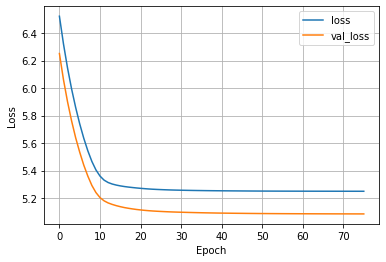

In [33]:
plot_loss(history, exp = True)

In [34]:
np.exp(model.evaluate(x = X_test,  y = y_test, verbose=1, batch_size = 16))

104/104 [==============================] - 0s 2ms/step - loss: 1.7015


5.482257594337253